In [1]:
# explore using no atlas at all. could be non-imaging data
from mismatch.TNMismatchClustering import TNMismatchClustering

clust = TNMismatchClustering()

# Run full pipeline
outputs = clust.run_pipeline(
    input_csv="/project/wolk/xyl/tn_mismatch/tn_mismatch/test/data/ADNI_A_pos_braincolor.csv",
    independent="tau",
    predict="thickness",
    n_clusters=6,
    output_prefix="tn_mismatch/demo_run",
    log_transform=True,
    generate_maps=True  
)

                               🌟 Welcome to the Mismatch Universe! 🌟                                
             🧠 PATCH Lab warmly welcomes you to explore brain heterogenity together!! 😊             
🗺️  Using predefined atlas: None
👤 Number of subjects: 184
🧠 Number of ROIs: 100

📈 Pearson correlation summary between independent and dependent variables:
  - 29 out of 100 ROIs show significant correlation (p < 0.05)
  - 11 out of 100 ROIs show a trend (0.05 < p < 0.1)
📈 Running robust bisquare regression...
📊 Using residuals for clustering (SD=1.5)...
🔗 Running Ward.D2 clustering...

📊 Cluster Membership Counts:
  Cluster 1: 99 subjects
  Cluster 2: 20 subjects
  Cluster 3: 16 subjects
  Cluster 4: 17 subjects
  Cluster 5: 5 subjects
  Cluster 6: 27 subjects
🖼️ Residual heatmap saved for Cluster 1 at: tn_mismatch/demo_run_cluster_heatmaps/cluster_1_residuals.png
🖼️ Residual heatmap saved for Cluster 2 at: tn_mismatch/demo_run_cluster_heatmaps/cluster_2_residuals.png
🖼️ Residual heatm

In [3]:
from mismatch.MTLSuperPoints import create_MTLSuperPoints


In [11]:
from mismatch.MTLSuperPoints import create_MTLSuperPoints

# Define the arguments directly
left_csv = "/project/wolk/xyl/tn_mismatch/tn_mismatch/test/data/subjects_with_thickness_paths_left.csv"
right_csv = "/project/wolk/xyl/tn_mismatch/tn_mismatch/test/data/subjects_with_thickness_paths_right.csv"
template_left = "/project/wolk/xyl/tn_mismatch/tn_mismatch/template/template_shoot_left.vtk"
template_right = "/project/wolk/xyl/tn_mismatch/tn_mismatch/template/template_shoot_right.vtk"
output_dir = "/project/wolk/xyl/mismatch/tn_mismatch/test/output"
num_partitions = 50
final_csv = "/project/wolk/xyl/mismatch/tn_mismatch/test/final_output.csv"

# Call the pipeline function
results = create_MTLSuperPoints(
    left_csv=left_csv,
    right_csv=right_csv,
    template_left=template_left,
    template_right=template_right,
    output_dir=output_dir,
    num_partitions=num_partitions,
    final_csv=final_csv
)



✅ VTK saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/118700_20240513_partitioned_left.vtk
✅ Mean thickness saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/mean_thickness_118700_20240513_left.txt
✅ VTK saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/123727_20240209_partitioned_left.vtk
✅ Mean thickness saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/mean_thickness_123727_20240209_left.txt
✅ VTK saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/125429_20240314_partitioned_left.vtk
✅ Mean thickness saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/mean_thickness_125429_20240314_left.txt
✅ VTK saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/126811_20240301_partitioned_left.vtk
✅ Mean thickness saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/mean_thickness_126811_20240301_left.txt
✅ VTK saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/126882_20240709_partitioned_left.vtk
✅ Mean thickness saved: /project/wo

✅ VTK saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/132008_20240906_partitioned_left.vtk
✅ Mean thickness saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/mean_thickness_132008_20240906_left.txt
✅ VTK saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/132063_20240524_partitioned_left.vtk
✅ Mean thickness saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/mean_thickness_132063_20240524_left.txt
✅ VTK saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/132213_20240516_partitioned_left.vtk
✅ Mean thickness saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/mean_thickness_132213_20240516_left.txt
✅ VTK saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/132219_20240612_partitioned_left.vtk
✅ Mean thickness saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/mean_thickness_132219_20240612_left.txt
✅ VTK saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/132282_20240928_partitioned_left.vtk
✅ Mean thickness saved: /project/wo

✅ VTK saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/131467_20240424_partitioned_right.vtk
✅ Mean thickness saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/mean_thickness_131467_20240424_right.txt
✅ VTK saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/131717_20240521_partitioned_right.vtk
✅ Mean thickness saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/mean_thickness_131717_20240521_right.txt
✅ VTK saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/131728_20240224_partitioned_right.vtk
✅ Mean thickness saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/mean_thickness_131728_20240224_right.txt
✅ VTK saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/131797_20241216_partitioned_right.vtk
✅ Mean thickness saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/mean_thickness_131797_20241216_right.txt
✅ VTK saved: /project/wolk/xyl/mismatch/tn_mismatch/test/output/131908_20240307_partitioned_right.vtk
✅ Mean thickness saved: /p

In [6]:
import pandas as pd

df = pd.read_csv("/project/wolk/xyl/mismatch/tn_mismatch/test/final_output.csv")
df.head()


,ID,MRIDATE,x_left_0,x_left_1,x_left_2,x_left_3,x_left_5,x_left_6,x_left_7,x_left_8,...,x_right_40,x_right_41,x_right_42,x_right_43,x_right_44,x_right_45,x_right_46,x_right_47,x_right_48,x_right_49
0,118700,20240513,4.3903,5.9058,7.2182,7.1496,3.9949,6.1256,3.0650,5.4547,...,2.7753,2.1163,2.8971,2.3953,2.2600,2.6588,2.3701,3.2986,2.5636,2.2959
1,123727,20240209,4.4364,8.0821,7.6602,6.4649,4.4723,4.4153,2.7239,5.7156,...,3.1629,2.2171,2.2252,1.7727,1.9089,2.2812,2.3244,2.9426,2.2472,2.2173
2,125429,20240314,4.5472,7.0066,6.8724,5.6324,4.1754,5.2050,2.1200,4.4980,...,3.2546,2.4746,2.2264,2.0430,2.1215,2.4255,2.3105,2.9582,2.2784,2.9302
3,126811,20240301,4.3740,8.3757,8.4293,6.7184,3.8001,4.7428,3.5425,4.9171,...,3.1176,2.3507,4.1107,2.6814,2.8726,3.7268,2.1265,4.4928,2.9575,2.7125
4,126882,20240709,4.7882,6.9301,7.8420,6.6655,3.8533,3.7838,2.5114,5.3548,...,2.1391,1.5486,2.5366,2.1213,2.1463,2.5930,2.2391,2.9714,2.4823,2.3740


In [12]:
results['final_df']

TypeError: 'NoneType' object is not subscriptable

In [13]:
from mismatch.TNMismatchClustering import TNMismatchClustering






In [3]:
#import importlib
#import mismatch_clustering_class
#importlib.reload(mismatch_clustering_class)



pipeline = TNMismatchClustering(atlas="DKT")
results = pipeline.run_pipeline(
    input_csv="/project/wolk/xyl/tn_mismatch/tn_mismatch/Fake_DKT_input_with_Covariates2.csv",
    independent="tau",
    predict="thickness",
    sd_thresh=1.5,
    output_prefix="results/output",
    log_transform=True,
    covariates=["age", "*amyloid", "time"]  # example usage
)


                               🌟 Welcome to the Mismatch Universe! 🌟                                
             🧠 PATCH Lab warmly welcomes you to explore brain heterogenity together!! 😊             
🗺️  Using predefined atlas: DKT
👤 Number of subjects: 50
🧠 Number of ROIs: 62

📈 Pearson correlation summary between independent and dependent variables:
  - 30 out of 62 ROIs show significant correlation (p < 0.05)
  - 6 out of 62 ROIs show a trend (0.05 < p < 0.1)
📈 Running robust bisquare regression...
    - Global covariates used: age
    - ⚠️ Global covariates NOT found and skipped: time
    - ROI-specific covariate used in 7 out of 62 ROIs: amyloid
📊 Using residuals for clustering (SD=1.5)...
🔗 Running Ward.D2 clustering...

🔎 Auto-selecting number of clusters based on elbow method...
📐 Optimal number of clusters estimated: 5

📊 Cluster Membership Counts:
  Cluster 1: 7 subjects
  Cluster 2: 5 subjects
  Cluster 3: 4 subjects
  Cluster 4: 4 subjects
  Cluster 5: 30 subjects
🖼️ Resi

In [6]:
# explore using braincolor atlas
from mismatch.TNMismatchClustering import TNMismatchClustering

clust = TNMismatchClustering(atlas="BrainCOLOR")

# 🧠 Initialize with predefined atlas (or use custom_atlas_path + custom_label_csv)



# 📄 Path to your data
input_csv = "/project/wolk/xyl/tn_mismatch/tn_mismatch/test/data/ADNI_A_pos_braincolor.csv"  # Replace with your actual file
independent = "tau"              # E.g., column like entorhinal_tau
predict = "thickness"            # E.g., column like entorhinal_thickness
output_prefix = "demo_run"

# 🧪 Run full pipeline
outputs = clust.run_pipeline(
    input_csv=input_csv,
    independent=independent,
    predict=predict,
    sd_thresh=1.5,        
    n_clusters=6,      # Auto-estimate if None
    output_prefix=output_prefix,
    log_transform=True,   # Apply log10 to tau
    generate_maps=True    # Save cluster-wise NIfTI maps
)




                               🌟 Welcome to the Mismatch Universe! 🌟                                
             🧠 PATCH Lab warmly welcomes you to explore brain heterogenity together!! 😊             
🗺️  Using predefined atlas: BrainCOLOR
👤 Number of subjects: 184
🧠 Number of ROIs: 100

📈 Pearson correlation summary between independent and dependent variables:
  - 29 out of 100 ROIs show significant correlation (p < 0.05)
  - 11 out of 100 ROIs show a trend (0.05 < p < 0.1)
📈 Running robust bisquare regression...
📊 Using residuals for clustering (SD=1.5)...
🔗 Running Ward.D2 clustering...

📊 Cluster Membership Counts:
  Cluster 1: 99 subjects
  Cluster 2: 20 subjects
  Cluster 3: 16 subjects
  Cluster 4: 17 subjects
  Cluster 5: 5 subjects
  Cluster 6: 27 subjects
🖼️ Residual heatmap saved for Cluster 1 at: demo_run_cluster_heatmaps/cluster_1_residuals.png
🧠 Residual map for cluster 1 saved to: demo_run_cluster_heatmaps/cluster_1_residual_map.nii.gz
🖼️ Residual heatmap saved for Clus

In [10]:
# explore using customized atlas

# Initialize with custom atlas + label CSV
clust = TNMismatchClustering(
    custom_atlas_path="/project/wolk/xyl/tn_mismatch/tn_mismatch/preprocess/antsMalfLabeling.nii.gz",
    custom_label_csv="/project/wolk/xyl/tn_mismatch/tn_mismatch/preprocess/custom_labels.csv"
)

# Run full pipeline
outputs = clust.run_pipeline(
    input_csv="/project/wolk/xyl/tn_mismatch/tn_mismatch/test/data/ADNI_A_pos_braincolor.csv",
    independent="tau",
    predict="thickness",
    sd_thresh=0,
    n_clusters=6,
    output_prefix="tn_mismatch/demo_run",
    log_transform=True,
    generate_maps=True  
)


                               🌟 Welcome to the Mismatch Universe! 🌟                                
             🧠 PATCH Lab warmly welcomes you to explore brain heterogenity together!! 😊             
🗺️  Using predefined atlas: None
👤 Number of subjects: 184
🧠 Number of ROIs: 100

📈 Pearson correlation summary between independent and dependent variables:
  - 29 out of 100 ROIs show significant correlation (p < 0.05)
  - 11 out of 100 ROIs show a trend (0.05 < p < 0.1)
📈 Running robust bisquare regression...
📊 Using residuals for clustering (SD=0)...
🔗 Running Ward.D2 clustering...

📊 Cluster Membership Counts:
  Cluster 1: 58 subjects
  Cluster 2: 23 subjects
  Cluster 3: 23 subjects
  Cluster 4: 52 subjects
  Cluster 5: 14 subjects
  Cluster 6: 14 subjects
🖼️ Residual heatmap saved for Cluster 1 at: tn_mismatch/demo_run_cluster_heatmaps/cluster_1_residuals.png
🧠 Residual map for cluster 1 saved to: tn_mismatch/demo_run_cluster_heatmaps/cluster_1_residual_map.nii.gz
🖼️ Residual heatm

In [11]:

# Residuals with subject IDs and cluster labels
outputs["residual_df"].head()


# Clustering labels and mismatch scores
outputs["cluster_df"].head()


# Final cluster + subtype label assignment
outputs["final_df"].head()


# CSVs
print("Residual CSV path:", outputs["residual_csv"])
print("Cluster label CSV path:", outputs["cluster_csv"])
print("Cluster label + subtype name CSV path:", outputs["final_csv"])

# Full-cohort residual heatmap
print("All-subjects residual heatmap:", outputs["all_subjects_heatmap"])

# Residual heatmap image for each cluster
for cid, path in outputs["cluster_heatmaps"]:
    print(f"Cluster {cid} heatmap: {path}")

# Residual NIfTI map for each cluster (if enabled)
for cid, path in outputs["cluster_nifti_maps"]:
    print(f"Cluster {cid} NIfTI map: {path}")



Residual CSV path: tn_mismatch/demo_run_residuals.csv
Cluster label CSV path: tn_mismatch/demo_run_clusters.csv
Cluster label + subtype name CSV path: tn_mismatch/demo_run_clusters_with_names.csv
All-subjects residual heatmap: tn_mismatch/demo_run_residual_heatmap_all.png
Cluster 1 heatmap: tn_mismatch/demo_run_cluster_heatmaps/cluster_1_residuals.png
Cluster 2 heatmap: tn_mismatch/demo_run_cluster_heatmaps/cluster_2_residuals.png
Cluster 3 heatmap: tn_mismatch/demo_run_cluster_heatmaps/cluster_3_residuals.png
Cluster 4 heatmap: tn_mismatch/demo_run_cluster_heatmaps/cluster_4_residuals.png
Cluster 5 heatmap: tn_mismatch/demo_run_cluster_heatmaps/cluster_5_residuals.png
Cluster 6 heatmap: tn_mismatch/demo_run_cluster_heatmaps/cluster_6_residuals.png
Cluster 1 NIfTI map: tn_mismatch/demo_run_cluster_heatmaps/cluster_1_residual_map.nii.gz
Cluster 2 NIfTI map: tn_mismatch/demo_run_cluster_heatmaps/cluster_2_residual_map.nii.gz
Cluster 3 NIfTI map: tn_mismatch/demo_run_cluster_heatmaps/clus

In [12]:
outputs["residual_df"].head()


,ID,31_thickness,32_thickness,47_thickness,48_thickness,100_thickness,101_thickness,102_thickness,103_thickness,104_thickness,...,199_thickness,200_thickness,201_thickness,202_thickness,203_thickness,204_thickness,205_thickness,206_thickness,207_thickness,T_N_cluster
0,068_S_0210,0.769353,0.180073,0.457232,0.131670,-0.568673,0.324901,0.326341,0.231436,0.035091,...,0.068878,0.158995,0.171155,-0.143079,-0.247594,0.106649,0.064436,-0.207084,0.078505,1
1,037_S_0377,-0.452571,0.042256,-0.745962,0.420039,-0.850888,-0.788980,-0.617831,-0.315878,-0.535360,...,-0.116669,-0.286564,-0.458490,-0.894432,-0.571097,-0.419667,-0.319134,-0.558121,-0.337607,4
2,114_S_0416,-0.215343,-0.149144,-0.095431,-0.477884,0.383933,0.408717,0.109106,0.216091,1.031924,...,-0.198457,-0.160538,-0.288550,-0.078790,-0.093988,0.099930,0.041729,0.059684,-0.146473,4
3,037_S_0467,-1.010111,-1.740171,-1.097153,-0.798798,-0.540873,-0.275737,-0.844566,-0.772652,0.332022,...,0.379272,-0.769817,-0.644724,-0.207993,-0.241177,-0.155424,-0.463809,-0.418384,-0.472881,6
4,021_S_0626,-1.089763,-2.100433,-0.893365,-0.427806,-0.617257,-0.397792,0.122265,-0.719760,0.099284,...,-0.484948,-0.494893,-0.788857,-1.307010,-1.661810,-0.371034,-0.659554,-0.156695,-0.357346,5


In [13]:
outputs["cluster_df"].head()


,ID,T_N_cluster,Global_Mismatch_Score
0,068_S_0210,1,-2.100937
1,037_S_0377,4,44.320351
2,114_S_0416,4,11.699369
3,037_S_0467,6,18.734019
4,021_S_0626,5,61.287688


In [14]:
outputs["final_df"].head()


,ID,T_N_cluster,Global_Mismatch_Score,Cluster_Label
0,068_S_0210,1,-2.100937,Likely Resilient
1,037_S_0377,4,44.320351,Likely Vulnerable
2,114_S_0416,4,11.699369,Likely Vulnerable
3,037_S_0467,6,18.734019,Likely Vulnerable
4,021_S_0626,5,61.287688,Likely Vulnerable


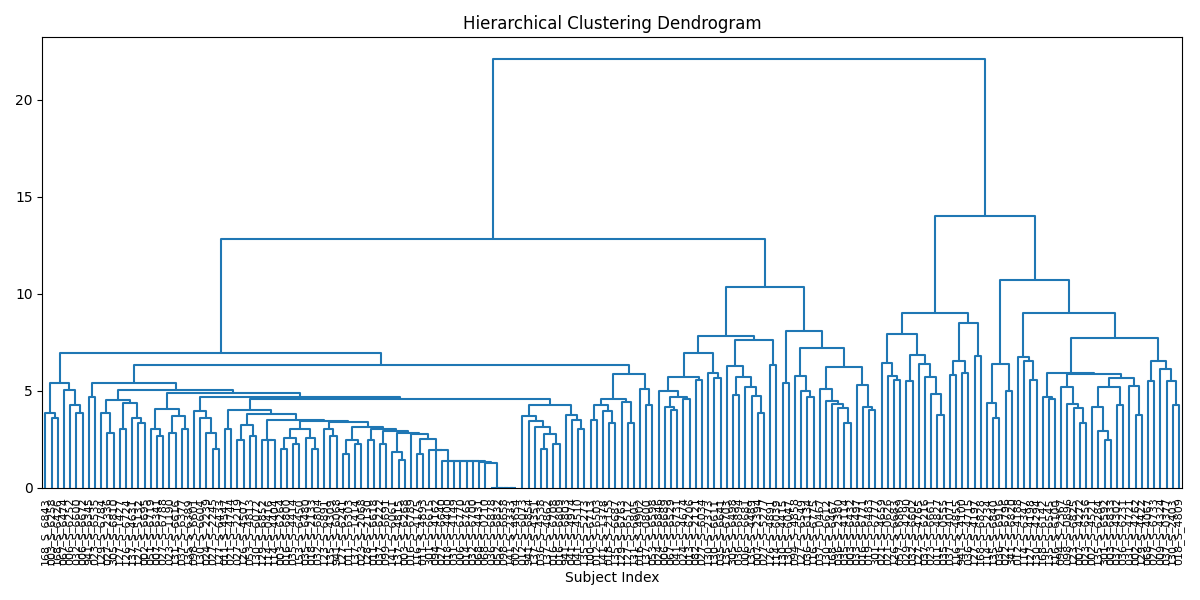

In [19]:

from IPython.display import Image, display

display(Image(filename="tn_mismatch/demo_run_dendrogram.png"))


Showing Cluster 1 Heatmap:


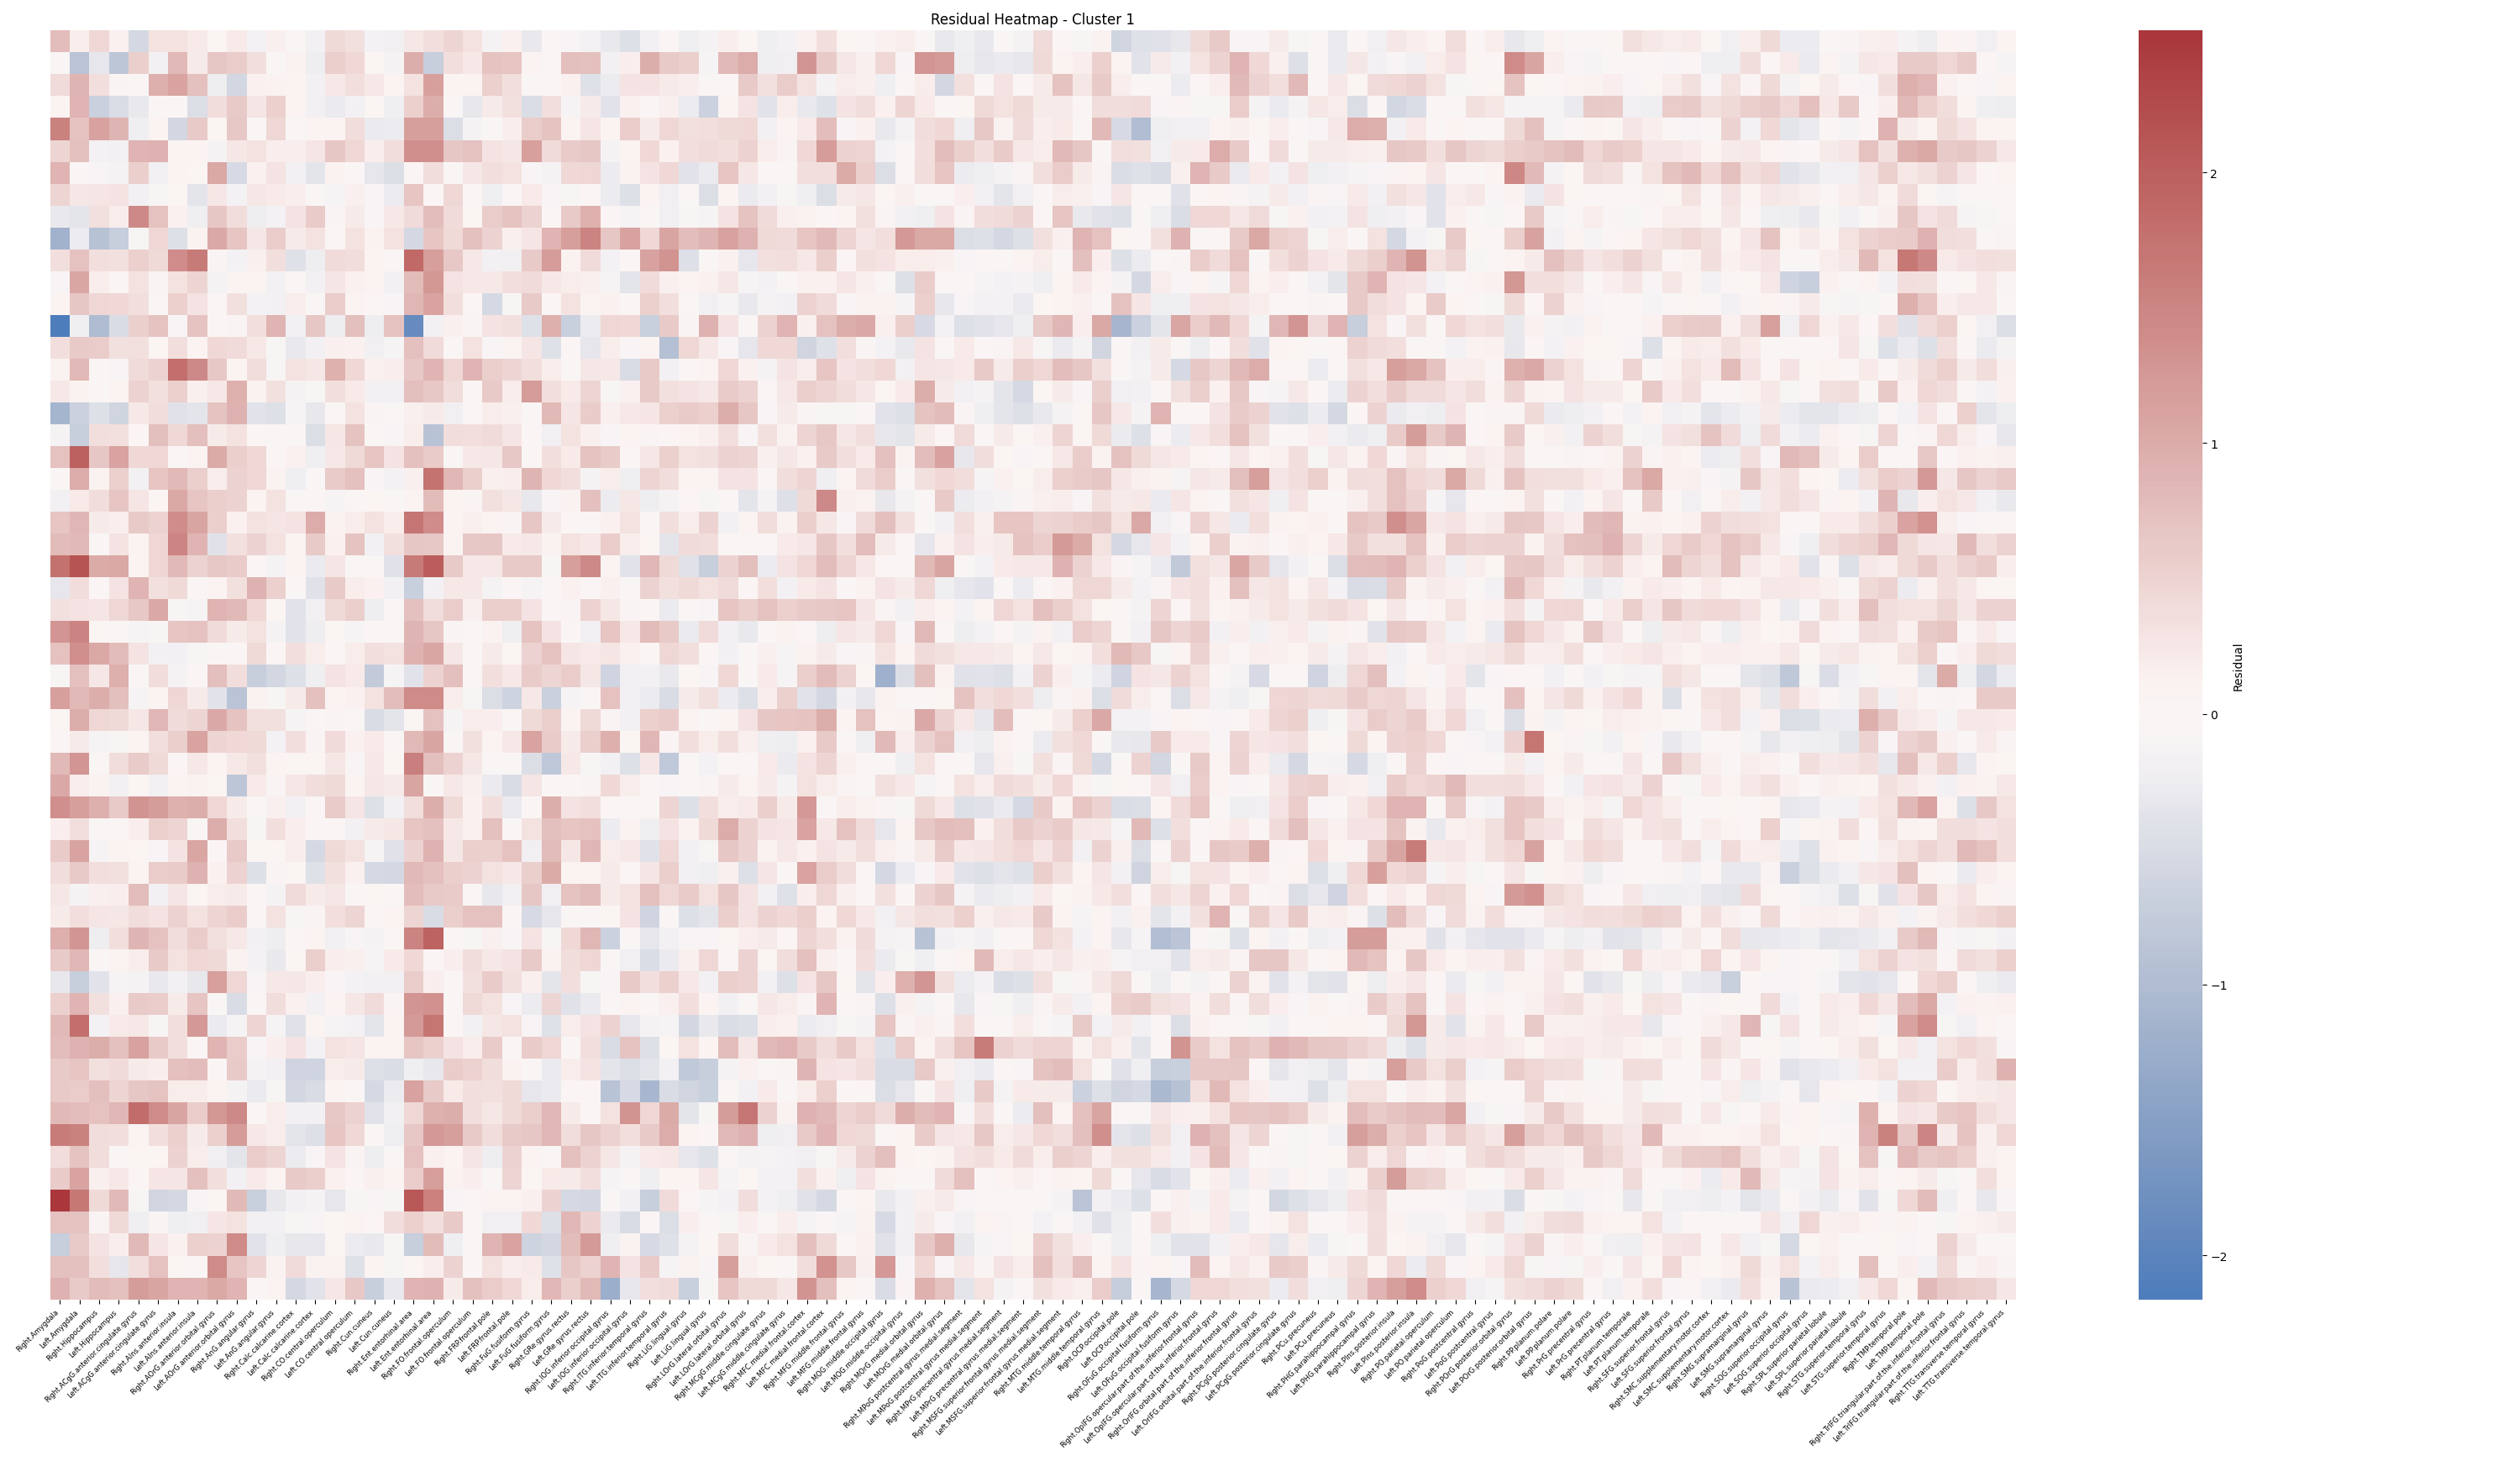

Showing Cluster 2 Heatmap:


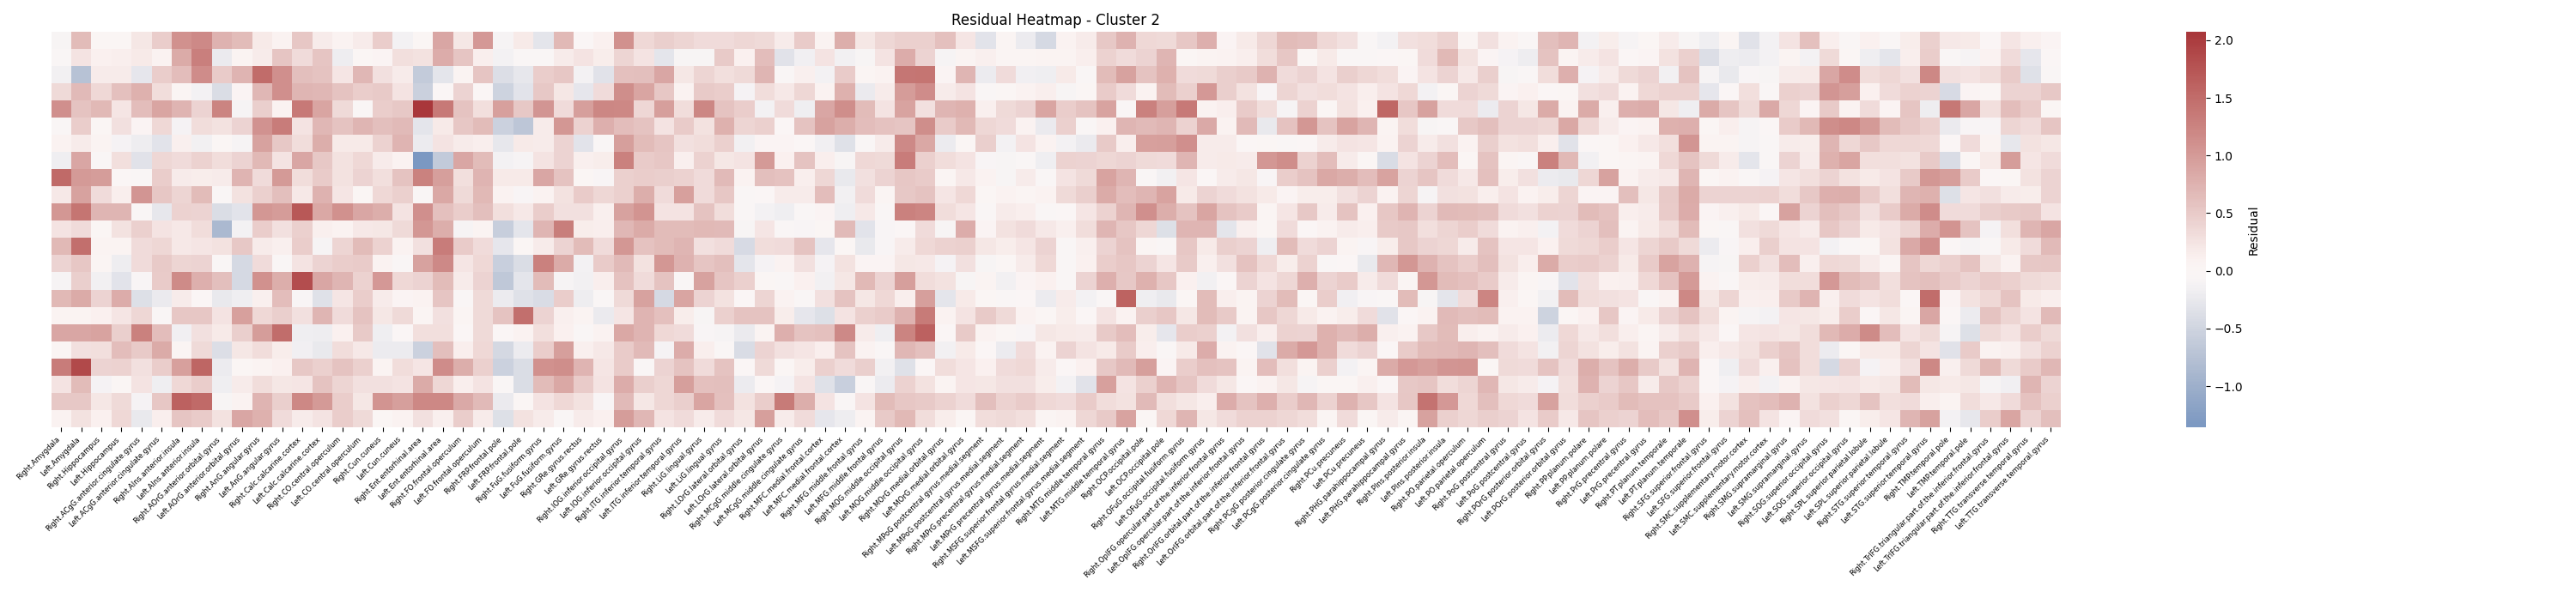

Showing Cluster 3 Heatmap:


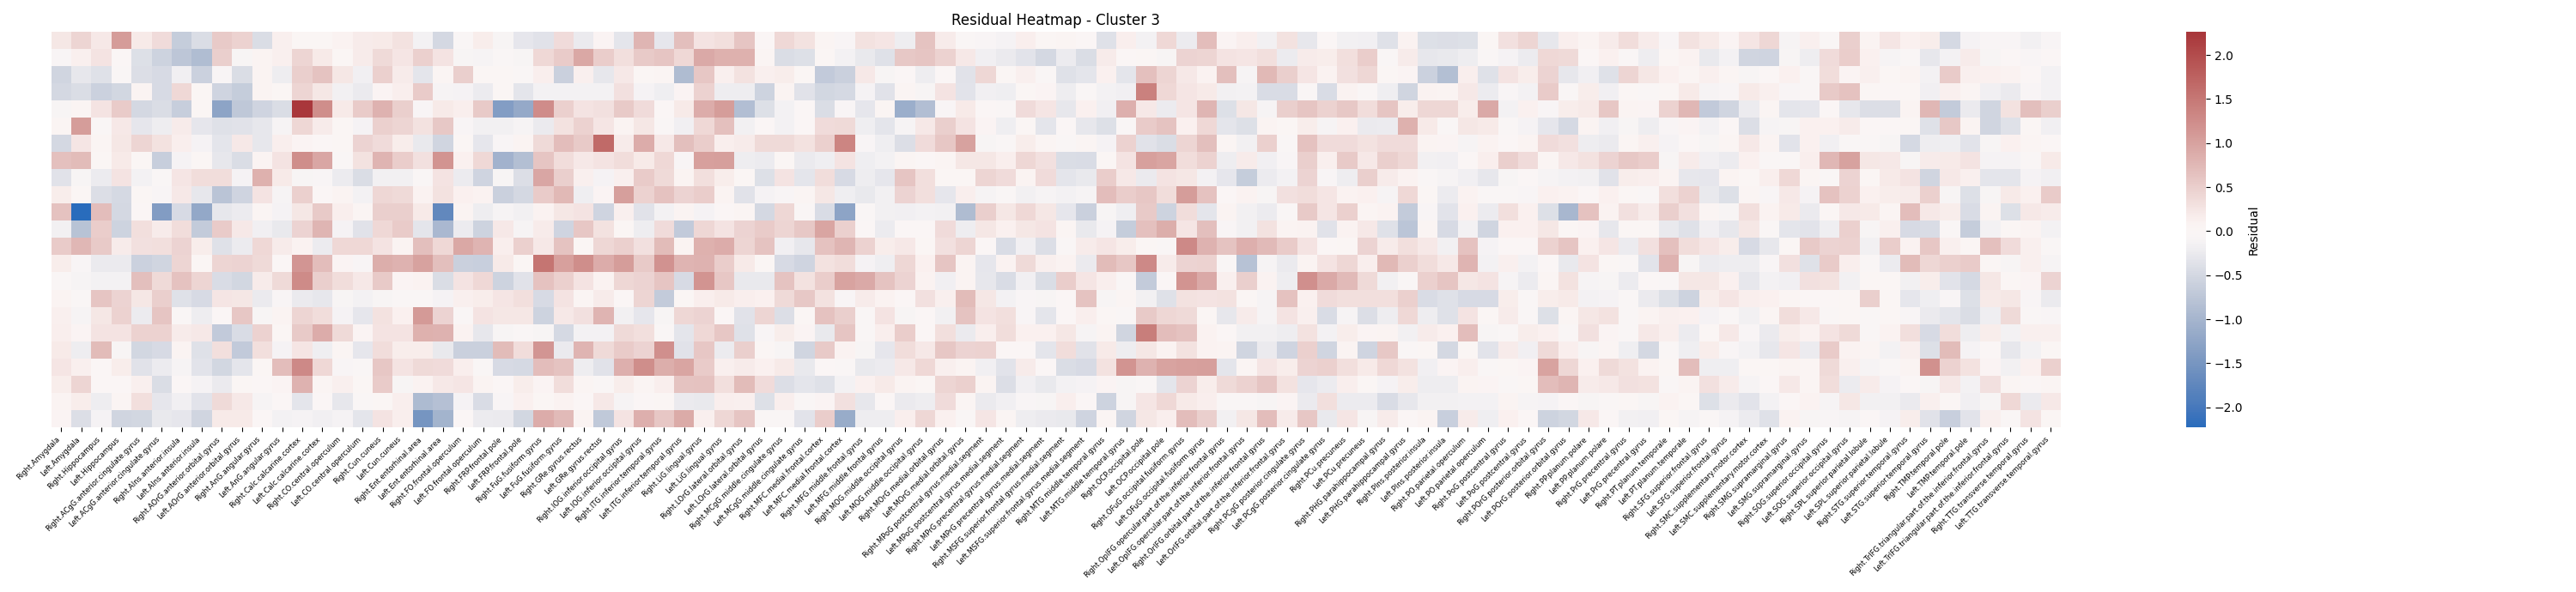

Showing Cluster 4 Heatmap:


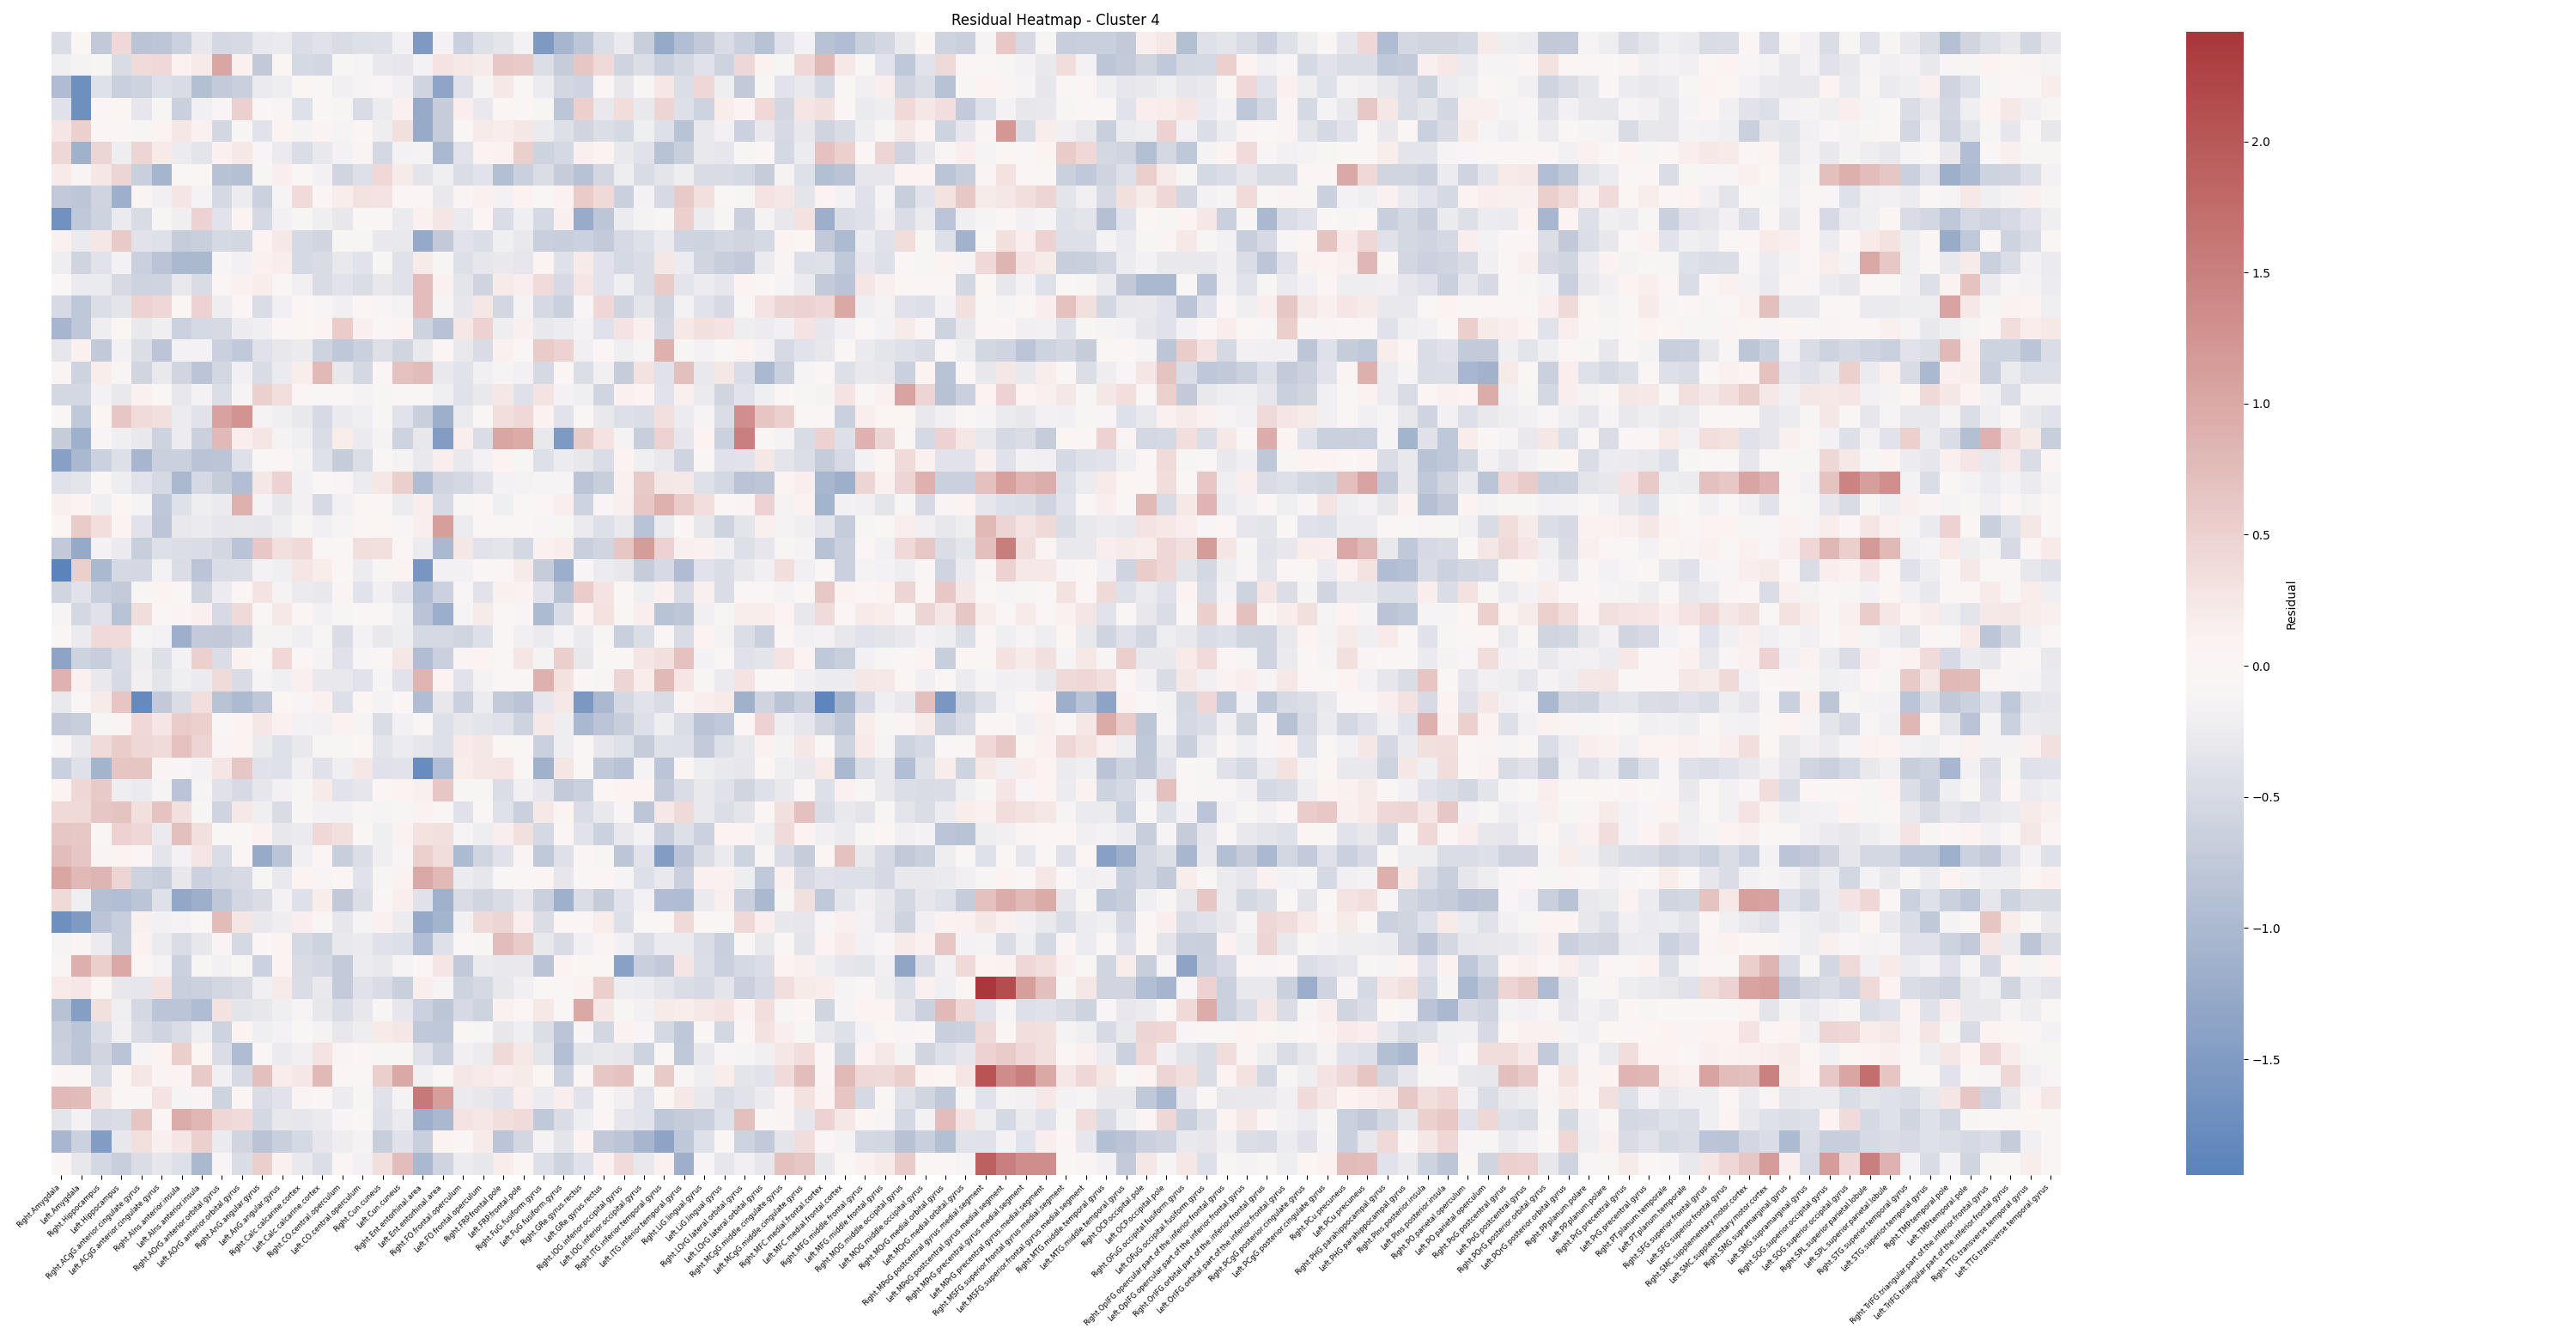

Showing Cluster 5 Heatmap:


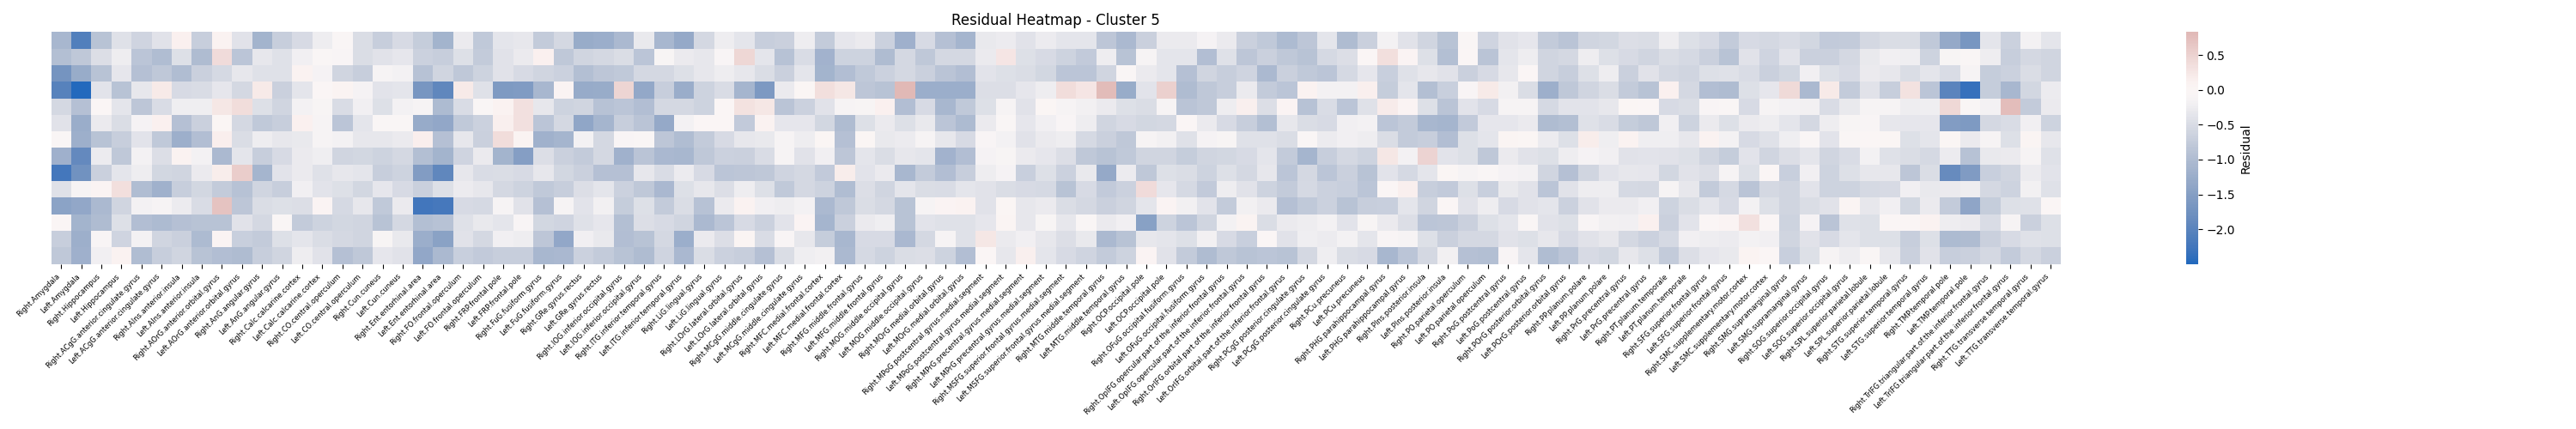

Showing Cluster 6 Heatmap:


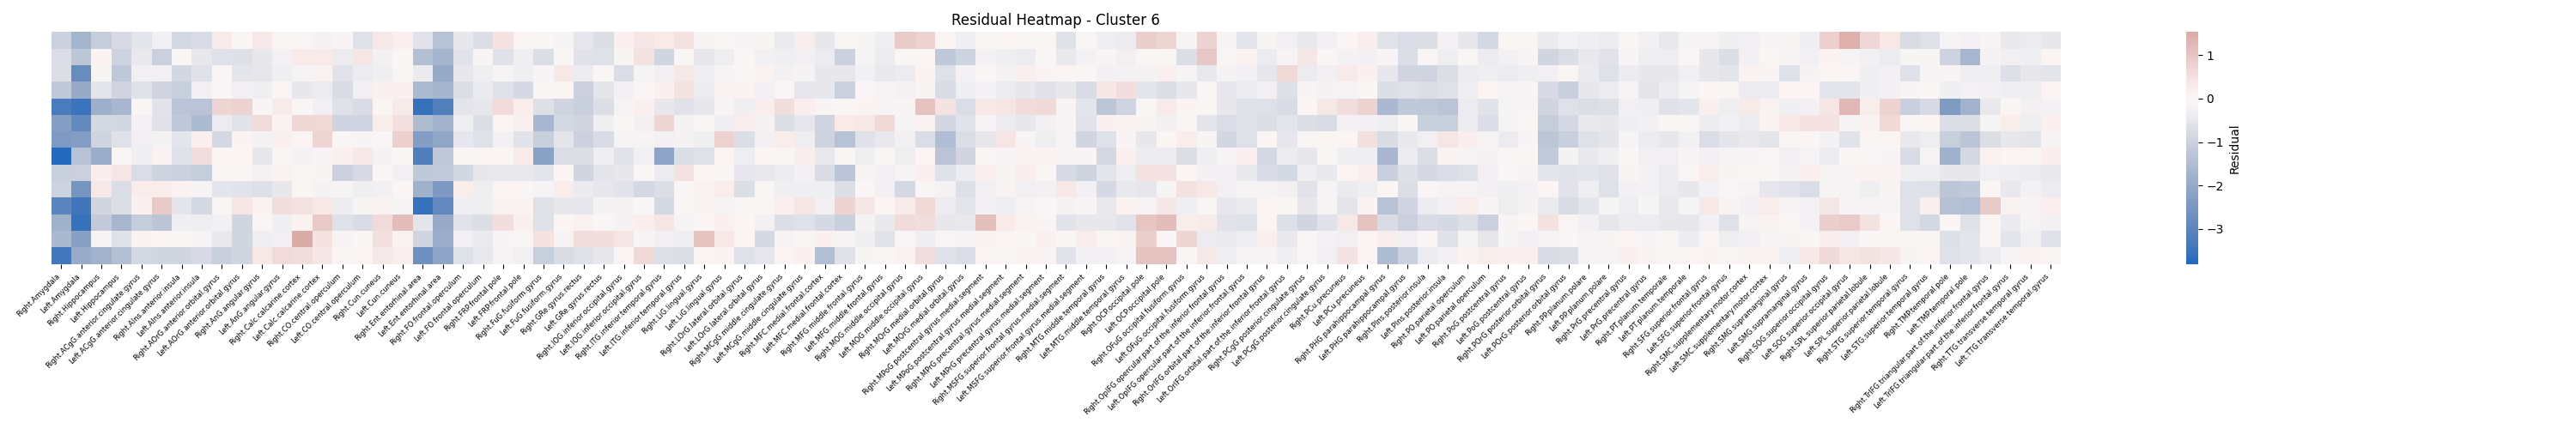

In [15]:
from IPython.display import Image, display

# Show all saved PNGs (cluster heatmaps)
for cid, path in outputs["cluster_heatmaps"]:
    print(f"Showing Cluster {cid} Heatmap:")
    display(Image(filename=path))


In [16]:
import nibabel as nib

nifti_images = {}  # Dictionary to store loaded NIfTI images

for cluster_id, path in outputs["cluster_nifti_maps"]:
    img = nib.load(path)
    nifti_images[cluster_id] = img
    print(f"Loaded cluster {cluster_id} NIfTI with shape: {img.shape}")


Loaded cluster 1 NIfTI with shape: (256, 256, 170)
Loaded cluster 2 NIfTI with shape: (256, 256, 170)
Loaded cluster 3 NIfTI with shape: (256, 256, 170)
Loaded cluster 4 NIfTI with shape: (256, 256, 170)
Loaded cluster 5 NIfTI with shape: (256, 256, 170)
Loaded cluster 6 NIfTI with shape: (256, 256, 170)


In [5]:
#!pip install itkwidgets
#!pip install nilearn
#!pip install napari[all]


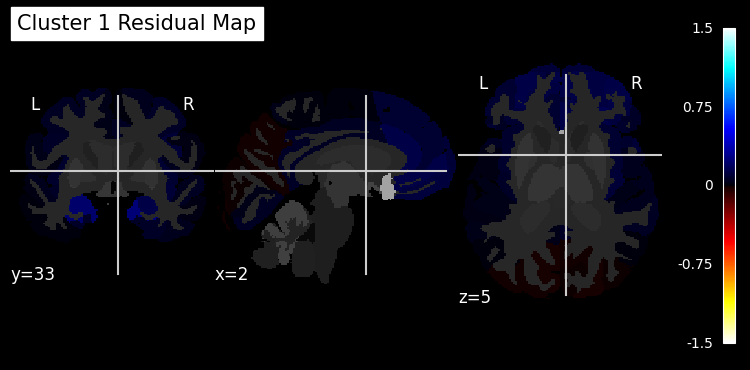

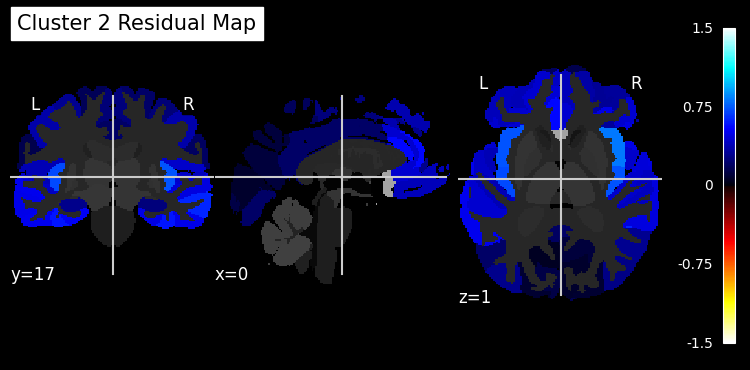

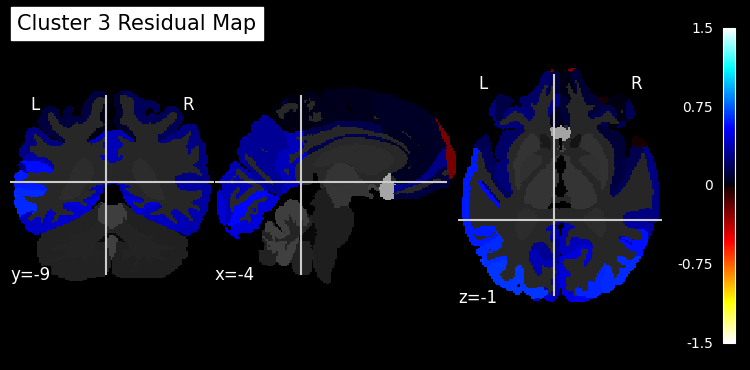

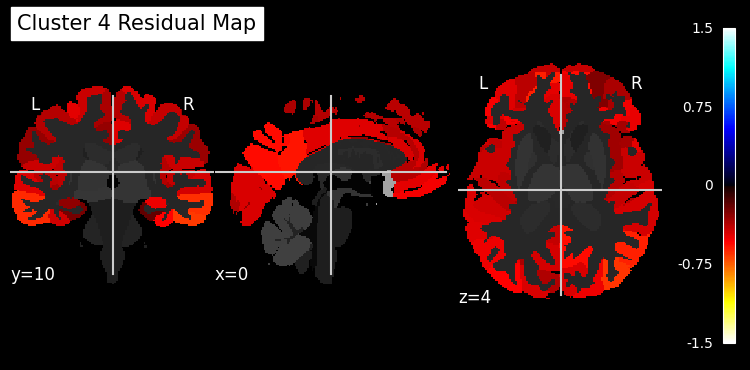

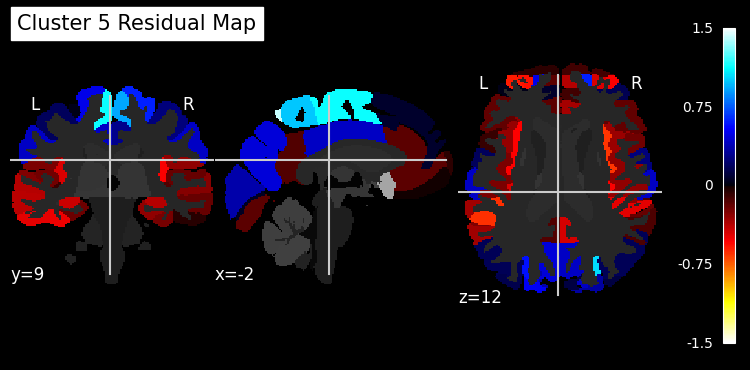

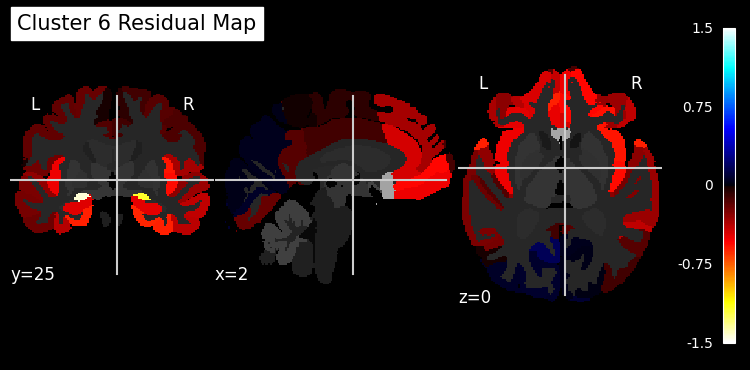

In [17]:
from nilearn import plotting
import nibabel as nib
import os

# Set paths
heatmap_dir = "demo_run_cluster_heatmaps"
bg_path = "/project/wolk/xyl/tn_mismatch/tn_mismatch/preprocess/antsMalfLabeling.nii.gz"
custom_bg = nib.load(bg_path)

# Loop and display in notebook
for cluster_id in range(1, 7):  # adjust range if needed
    map_path = os.path.join(heatmap_dir, f"cluster_{cluster_id}_residual_map.nii.gz")
    
    if os.path.exists(map_path):
        stat_map = nib.load(map_path)
        title = f"Cluster {cluster_id} Residual Map"

        display = plotting.plot_stat_map(
            stat_map,
            bg_img=custom_bg,
            threshold=0,
            cmap="cold_hot_r",
            colorbar=True,
            vmin=-1.5,
            vmax=1.5,
            title=title
        )
        plotting.show()  # This will render inline in Jupyter
    else:
        print(f"⚠️ Skipped missing file: {map_path}")


/bin/bash: /project/wolk/xyl/tn_mismatch/tn_mismatch/preprocess/mismatch_clustering6.py: Permission denied
